In [160]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
import matplotlib as matplotlib
from scipy import stats
from scipy.linalg import block_diag
import seaborn as sns

In [27]:
def _calc_D(s):
    # calc all the differences
    s0__1 = s[1:-1] - s[:-2]
    s1_0 = s[2:] - s[1:-1]
    s1__1 = s[2:] - s[:-2]

    # calc the -1, 0, and 1 diagonals
    A = -((s1_0/s1__1)/s0__1)
    B = -((s0__1/s1__1)/s1_0) + (s1_0/s1__1)/s0__1
    C = (s0__1/s1__1)/s1_0

    # create the matrix
    D = np.zeros((len(s), len(s)))
    D.flat[len(s):-2:len(s)+1] = A
    D.flat[len(s)+1:-1:len(s)+1] = B
    D.flat[len(s)+2::len(s)+1] = C
    
    return D.T
def my_mat_power(x, n, x0=None):
    if x0 is None:
        x0 = x
    if n == 1:
        return x
    elif n == 2:
        return np.dot(x, x0)
    elif n > 2:
        return my_mat_power(np.dot(x, x0), n-1, x0=x0)
    else:
        raise ValueError("Only positive n are allowed.")
    
def _calc_invL2(s, k):
    # calc finite differentiation matrix from s
    D = np.float128(_calc_D(np.float128(s)))
    
    # Post inverse Laplace linear operator
    #invL = (((-1.) ** k) / factorial(k)) * \
    #        np.dot(np.linalg.matrix_power(D, k), np.diag(s ** (k+1)))[:, k:-k]
    invL = (((-1.) ** k) * \
            my_mat_power(D, k) * np.exp(np.log(s)*(k+1) - 
                                        np.log(np.arange(2,k+1)).sum()))[:, k:-k]
    

    # return as ndarray
    return np.float64(invL)

In [28]:
class iSITH():
    def __init__(self, tau_min=.1, tau_max=20., k=8, ntau=50, dt=0.01, g=0.0):
        self.k = k
        self.tau_min = tau_min
        self.tau_max = tau_max
        self.ntau = ntau
        self.dt = dt
        self.g = g

        self.c = (self.tau_max/self.tau_min)**(1./(self.ntau-1))-1
        tau_star = self.tau_min * (1 + self.c)**np.arange(-self.k, self.ntau + self.k)
        self.s = (1/tau_star)
        self.invL = _calc_invL2(self.s, k)

In [120]:
k = 8
ntau = 30
dt = 0.01
tau_min = 0.1
tau_max = 10
tmax = tau_max*2
nsteps = tmax/dt

## Pair-wise association between X and Y, with X presented at t=0 and Y presented at t=tmax:

In [121]:
Sith = iSITH(tau_min=tau_min,tau_max=tau_max,ntau=ntau,k=k)
nt = len(Sith.s)
steps = np.arange(1,nsteps)
F_t = np.full(nt,1)
for t in steps:
    vals = 1 * np.exp(-Sith.s * (dt*t))
    F_t = np.vstack([F_t,vals])

### Association between X and Y are stored at the time of Y's presentation in M. Input into the prediction population, P_IN, is based on the value stored in M and a learning rate $\alpha$. Assuming full learning ($\alpha = 1$), P_IN is equal to the stored values.

In [122]:
PIN = F_t[-1]
P_t = PIN
for t in steps:
    vals = PIN * np.exp(Sith.s * (dt*t))
    P_t = np.vstack([P_t,vals])

/tmp/ipykernel_38012/999449580.py:4: RuntimeWarning: overflow encountered in exp
  vals = PIN * np.exp(Sith.s * (dt*t))


/tmp/ipykernel_38012/2285393583.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axF[0,0].set_xticklabels(np.concatenate(([0],np.arange(0,tmax+2.5,2.5))))
/tmp/ipykernel_38012/2285393583.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axF[1,0].set_xticklabels(np.concatenate(([0],np.arange(0,tmax+2.5,2.5))))
/tmp/ipykernel_38012/2285393583.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axF[0,1].set_xticklabels([0,10,20])
/tmp/ipykernel_38012/2285393583.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axF[0,1].set_xticklabels([0,10,20])
/tmp/ipykernel_38012/2285393583.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axF[0,1].set_xticklabels(np.concatenate(([0],np.arange(0,tmax+1,5))))
/tmp/ipykernel_38012/2285393583.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axF[1,1].set_x

<Figure size 640x480 with 0 Axes>

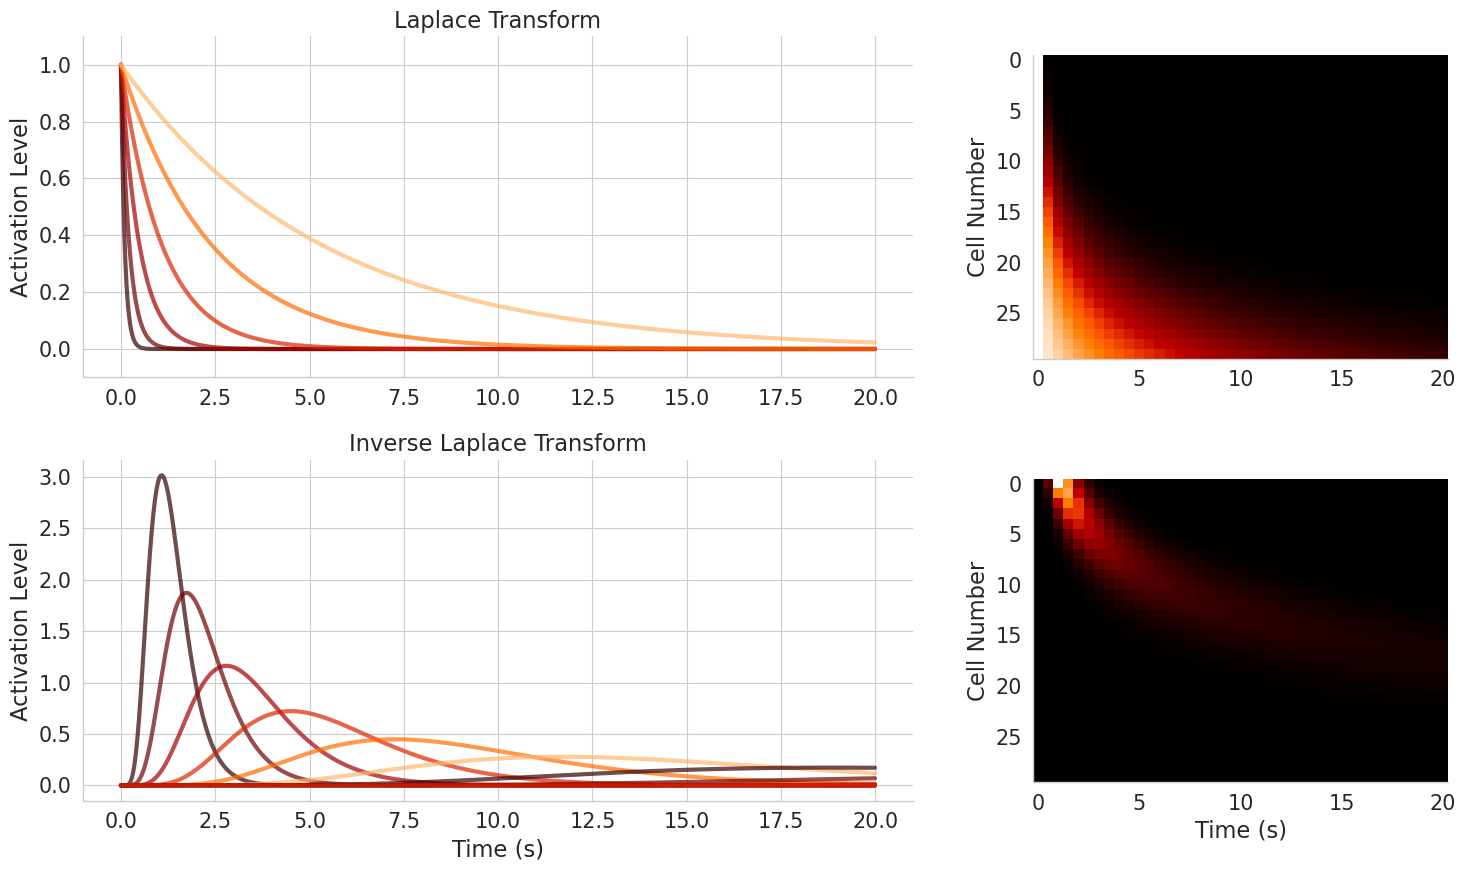

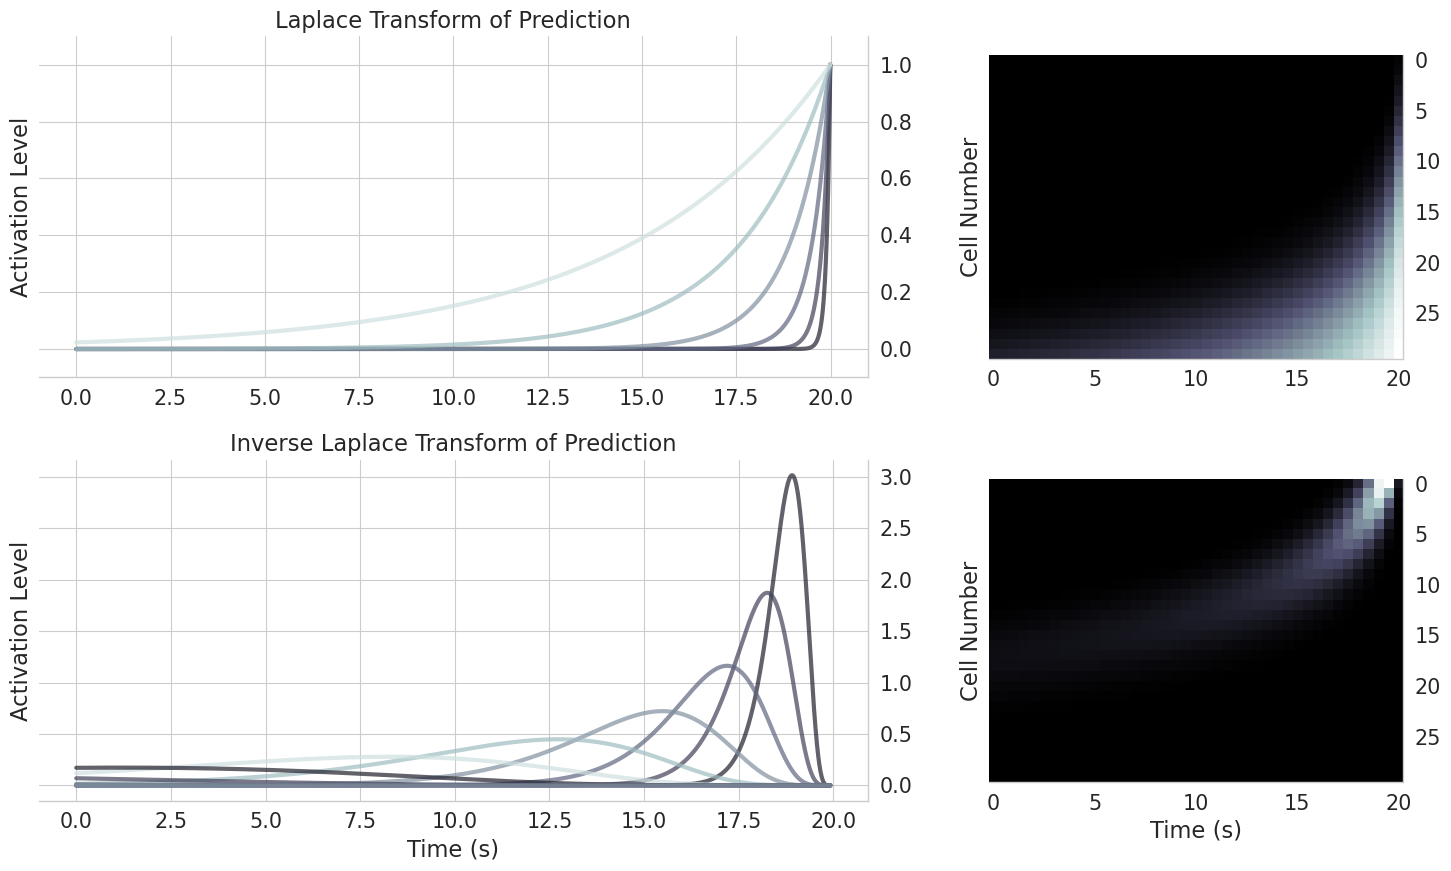

In [206]:
sns.set_theme(context='paper', style='whitegrid',palette='gist_heat',font_scale=1.7)
sns.despine()
#F plot
figF, axF = plt.subplots(2,2, figsize=(15,9), gridspec_kw={'width_ratios': [2, 1],'height_ratios': [1, 1]})
axF[0,0].set_ylim(-0.1,1.1)
axF[0,0].set_ylabel("Activation Level")
axF[0,0].set_title("Laplace Transform")
axF[1,0].set_ylabel("Activation Level")
axF[1,0].set_title("Inverse Laplace Transform")
axF[0,0].set_xticklabels(np.concatenate(([0],np.arange(0,tmax+2.5,2.5))))
axF[1,0].set_xticklabels(np.concatenate(([0],np.arange(0,tmax+2.5,2.5))))
axF[1,0].set_xlabel("Time (s)")

axF[0,1].set_ylabel("Cell Number")
#axF[0,1].set_title("Laplace Transform")
axF[1,1].set_ylabel("Cell Number")
#axF[1,1].set_title("Inverse Laplace Transform")
axF[0,1].set_xticklabels([0,10,20])
axF[0,1].set_xticklabels([0,10,20])
axF[0,1].set_xticklabels(np.concatenate(([0],np.arange(0,tmax+1,5))))
axF[1,1].set_xticklabels(np.concatenate(([0],np.arange(0,tmax+1,5))))
axF[1,1].set_xlabel("Time (s)")

figF.tight_layout()

#P plot
sns.set_palette('bone')
figP, axP = plt.subplots(2,2, figsize=(15,9), gridspec_kw={'width_ratios': [2, 1],'height_ratios': [1, 1]})
axP[0,0].set_ylim(-0.1,1.1)
axP[0,0].set_ylabel("Activation Level")
axP[0,0].set_title("Laplace Transform of Prediction")
axP[1,0].set_ylabel("Activation Level")
axP[1,0].set_title("Inverse Laplace Transform of Prediction")
axP[0,0].set_xticklabels(np.concatenate(([0],np.arange(0,tmax+2.5,2.5))))
axP[1,0].set_xticklabels(np.concatenate(([0],np.arange(0,tmax+2.5,2.5))))
axP[1,0].set_xlabel("Time (s)")

axP[0,1].set_ylabel("Cell Number")
#axF[0,1].set_title("Laplace Transform")
axP[1,1].set_ylabel("Cell Number")
#axF[1,1].set_title("Inverse Laplace Transform")
axP[0,1].set_xticklabels([0,10,20])
axP[0,1].set_xticklabels([0,10,20])
axP[0,1].set_xticklabels(np.concatenate(([0],np.arange(0,tmax+1,5))))
axP[1,1].set_xticklabels(np.concatenate(([0],np.arange(0,tmax+1,5))))
axP[1,1].set_xlabel("Time (s)")

figP.tight_layout()

sns.despine(figF)
sns.despine(figP, left=True, right=False)

for i in np.arange(k,nt-k,5):
    axF[0,0].plot(F_t[:,i], lw=3,alpha=0.7)
inverseF = np.dot(F_t,Sith.invL)
axF[1,0].plot(inverseF[:,::3], lw=3, alpha=0.7);

axF[0,1].imshow(F_t[::49,k:k+ntau].T, cmap='gist_heat')
axF[1,1].imshow(inverseF[::49,:].T, cmap='gist_heat')
axF[0,1].grid(False)
axF[1,1].grid(False)

sns.set_palette('crest')
for i in np.arange(k,nt-k,5):
    axP[0,0].plot(P_t[:,i], lw=3,alpha=0.7)
inverseP = np.dot(P_t,Sith.invL)
axP[1,0].plot(inverseP[:,::3], lw=3, alpha=0.7);

axP[0,1].imshow(P_t[::49,k:k+ntau].T, cmap='bone')
axP[1,1].imshow(inverseP[::49,:].T, cmap='bone')
axP[0,1].grid(False)
axP[1,1].grid(False);